# Neuro-Symbolic AI
## Sort-of-CLEVR Dataset
### Contents
- Generate Dataset
- Perception Module
    - Train
    - Inference
- Semantic Parser
    - Preprocess Data
    - Train Seq2Seq Model
    - Inference
- Program Executor
- Plugging Everything Together

In [ ]:
# !git clone https://github.com/nerdimite/neuro-symbolic-ai-soc

In [ ]:
# cd neuro-symbolic-ai-soc

In [1]:
from data_generator import *
import numpy as np
import pandas as pd
import os
import dlib
import cv2
from skimage.io import imshow
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms as tfms
from PIL import Image

## Dataset Generation

### Breakdown

In [2]:
# Generate a sample i.e.
# a tuple of 1 image, 6 objects' properties, 20 QA vectors (10 relational and 10 non-relational)
sample = build_sample()

In [3]:
# Break down the sample
img, objects, queries, programs, answers = convert_sample(sample)

In [4]:
img = (img * 255).astype('uint8')

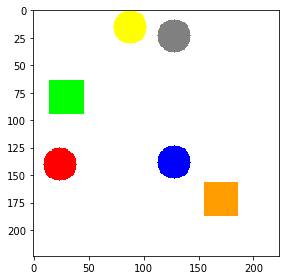

In [5]:
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
objects

[(0, array([ 24, 140]), 'c', (9, 125, 39, 155)),
 (1, array([30, 79]), 'r', (15, 64, 45, 94)),
 (2, array([128, 138]), 'c', (113, 123, 143, 153)),
 (3, array([171, 172]), 'r', (156, 157, 186, 187)),
 (4, array([128,  23]), 'c', (113, 8, 143, 38)),
 (5, array([88, 15]), 'c', (73, 0, 103, 30))]

In [58]:
list(zip(queries, answers, programs))

[('What is the closest shape to the orange object?',
  'circle',
  'filter orange <nxt> relate closest <nxt> query shape'),
 ('What is the furthest shape from the yellow object?',
  'rectangle',
  'filter yellow <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the yellow object?',
  'rectangle',
  'filter yellow <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the green object?',
  'rectangle',
  'filter green <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the green object?',
  'rectangle',
  'filter green <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the gray object?',
  'circle',
  'filter gray <nxt> relate furthest <nxt> query shape'),
 ('How many objects of the same shape as the red object are there?',
  '4',
  'filter red <nxt> query shape <nxt> filter <nxt> count'),
 ('What is the closest shape to the red object?',
  'rectangle',
  'filter red <nxt> relate clos

### Generate the full dataset

In [38]:
# Generate the dataset
n_train_imgs = 100
n_test_imgs = 10

build_dataset(n_train_imgs, data_dir='data/train', prefix='train')
build_dataset(n_test_imgs, data_dir='data/test', prefix='test')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34it/s]


## Perception Module

### Train the Object Detector

In [9]:
from perception import *

In [10]:
def load_image_data(csv_file, img_dir):
    '''Load the image detection data for training the object detector'''
    # Annotations
    annot = pd.read_csv(csv_file)
    
    data = {}
    for i in range(len(os.listdir(img_dir))):
        # Get all rows belonging to the same scene
        scene = annot[annot['filename'] == f'{i}.jpg']
        # Read the image
        img = cv2.imread(os.path.join(img_dir, f'{i}.jpg'))
        
        # Add bounding box information for dlib
        bboxes = []
        for row in scene.values:
            x1, y1, x2, y2 = row[-4:]
            dlib_box = dlib.rectangle(left=x1 , top=y1, right=x2, bottom=y2)
            bboxes.append(dlib_box)
        
        data[i] = (img, bboxes)
    
    return data

In [21]:
# Load the Image Detection Data
det_data = load_image_data('data/train/train_img_det.csv', 'data/train/images')

In [22]:
%%time
# Train the Model
train_detector(det_data, 'detector.svm')

Training Results: precision: 1, recall: 1, average precision: 1
Saved the model to detector.svm
Wall time: 7.35 s


### Shape Classifier

In [13]:
class Binarize():
    '''PyTorch Transforms Object'''
    def __init__(self):
        '''Converts Grayscale to Binary (except white every other color is zeroed)'''
        pass
    
    def __call__(self, img_tensor):
        '''
        Args:
            img_tensor (tensor): 0-1 scaled tensor with 1 channel
        Returns:
            tensor
        '''
        return (img_tensor > 0.95).float()

In [14]:
# Load the images
shapes_data = ImageFolder('data/shapes_data/', transform=tfms.Compose([tfms.Grayscale(), 
                                                                       tfms.Resize((40, 40)), 
                                                                       tfms.ToTensor(),
                                                                       Binarize()]))

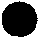

In [68]:
tfms.ToPILImage()(tfms.Compose([tfms.Grayscale(), 
               tfms.Resize((40, 40)), 
               tfms.ToTensor(),
               Binarize()])(Image.open('data/shapes_data/circle/2.jpg')))

In [15]:
shapes_data.class_to_idx

{'circle': 0, 'rectangle': 1}

In [16]:
# Create the dataloader
shapes_loader = DataLoader(shapes_data, batch_size=20, shuffle=True)

In [17]:
# Model
shape_classifier = ShapeClassifier()

In [18]:
# Train
shape_classifier.train_classifier(shapes_loader, lr=0.0001, epochs=50, filename='classifier.pth')

Epoch 1: Mean Loss = 0.6122248321771622



Epoch 2: Mean Loss = 0.446476752559344



Epoch 3: Mean Loss = 0.3697306861480077



Epoch 4: Mean Loss = 0.300445298353831



Epoch 5: Mean Loss = 0.22933848202228546



Epoch 6: Mean Loss = 0.15550924961765608



Epoch 7: Mean Loss = 0.1198902577161789



Epoch 8: Mean Loss = 0.11484716832637787



Epoch 9: Mean Loss = 0.10601623232165973



Epoch 10: Mean Loss = 0.12505624691645303



Epoch 11: Mean Loss = 0.08371285100777943



Epoch 12: Mean Loss = 0.056980022229254246



Epoch 13: Mean Loss = 0.048227459192276



Epoch 14: Mean Loss = 0.02641869615763426



Epoch 15: Mean Loss = 0.02822455856949091



Epoch 16: Mean Loss = 0.05707983300089836



Epoch 17: Mean Loss = 0.040227063155422606



Epoch 18: Mean Loss = 0.039098795503377914



Epoch 19: Mean Loss = 0.0415965278322498



Epoch 20: Mean Loss = 0.03643507712210218



Epoch 21: Mean Loss = 0.029656793068473537



Epoch 22: Mean Loss = 0.022696547210216522



Epoch 23: Mean Loss = 0.017155903081099193



Epoch 24: Mean Loss = 0.011138363896558682



Epoch 25: Mean Loss = 0.010340828681364655



Epoch 26: Mean Loss = 0.005885426692354183



Epoch 27: Mean Loss = 0.005873161251656711



Epoch 28: Mean Loss = 0.004020451568067074



Epoch 29: Mean Loss = 0.003012153688662996



Epoch 30: Mean Loss = 0.002884827166174849



Epoch 31: Mean Loss = 0.0037518057118480406



Epoch 32: Mean Loss = 0.003028400824405253



Epoch 33: Mean Loss = 0.0035134211260204515



Epoch 34: Mean Loss = 0.0053236423603569465



Epoch 35: Mean Loss = 0.0039443067119767266



Epoch 36: Mean Loss = 0.004255532966150592



Epoch 37: Mean Loss = 0.0056820823810994625



Epoch 38: Mean Loss = 0.005968043997806187



Epoch 39: Mean Loss = 0.00835680728778243



Epoch 40: Mean Loss = 0.008654865863112112



Epoch 41: Mean Loss = 0.00912008147376279



Epoch 42: Mean Loss = 0.007023111490222315



Epoch 43: Mean Loss = 0.006681709031302792



Epoch 44: Mean Loss = 0.006455630413256586



Epoch 45: Mean Loss = 0.005034443369368091



Epoch 46: Mean Loss = 0.005439353941862161



Epoch 47: Mean Loss = 0.0037254048741791244



Epoch 48: Mean Loss = 0.0038676020776620135



Epoch 49: Mean Loss = 0.005060952690352376



Epoch 50: Mean Loss = 0.0019846167124342173



### Perception Pipeline
`detector -> attribute (shape and color) extraction -> structural scene representation`

In [23]:
# Load the Model
perceiver = PerceptionPipe('detector.svm', 'classifier.pth', device='cuda')

### Breakdown

In [24]:
# Inference with Detector
objects = perceiver.detect(img)
objects

[(array([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [  0, 156, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255

In [25]:
# View the isolated objects (this will not work in colab as its headless)
# for obj, _ in objects:
#     cv2.imshow('frame', obj)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [26]:
# Inference with Attribute Extractor (Shape Classifier, Color Extractor)
shape, color = perceiver.extract_attributes(objects[3][0])
print(f'Shape = {shape}\nColor = {color}')

Shape = circle
Color = blue


### Pipeline

In [27]:
scene = perceiver.scene_repr(img)
scene

,shape,color,position
0,rectangle,orange,"(171, 172)"
1,circle,red,"(23, 140)"
2,circle,gray,"(127, 20)"
3,circle,blue,"(127, 136)"
4,rectangle,green,"(31, 80)"
5,circle,yellow,"(87, 17)"


## Semantic Parser

### Preprocess Data

In [28]:
from semantic_parser import *
from torchtext.data import BucketIterator

In [29]:
# Create the preprocessor object and preprocess
preproc = Preprocessor('data/train/train_q2p.csv')

In [30]:
# Get the dataset object
train_data = preproc.train_data

In [32]:
# Looking at the Vocabulary
preproc.prog_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x00000190813C2708>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '<nxt>': 4,
             'filter': 5,
             'query': 6,
             'shape': 7,
             'position': 8,
             'relate': 9,
             'orange': 10,
             'gray': 11,
             'count': 12,
             'isleft': 13,
             'istop': 14,
             'closest': 15,
             'red': 16,
             'yellow': 17,
             'furthest': 18,
             'blue': 19,
             'green': 20})

In [33]:
# Looking at the Vocabulary
preproc.que_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000001909E0138C8>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'the': 4,
             '?': 5,
             'object': 6,
             'is': 7,
             'shape': 8,
             'there': 9,
             'what': 10,
             'a': 11,
             'on': 12,
             'of': 13,
             'orange': 14,
             'gray': 15,
             'are': 16,
             'as': 17,
             'how': 18,
             'many': 19,
             'objects': 20,
             'same': 21,
             'left': 22,
             'top': 23,
             'closest': 24,
             'to': 25,
             'red': 26,
             'yellow': 27,
             'from': 28,
             'furthest': 29,
             'blue': 30,
             'green': 31})

### Training

In [34]:
# Training hyperparameters
num_epochs = 3
learning_rate = 3e-4
batch_size = 8
num_steps = len(train_data) / batch_size

# Model hyperparameters
config = {
    'que_vocab_size': len(preproc.que_f.vocab),
    'prog_vocab_size': len(preproc.prog_f.vocab),
    'embedding_dim': 256,
    'num_heads': 8,
    'num_encoder_layers': 3,
    'num_decoder_layers': 3,
    'dropout': 0.10,
    'max_len': 20,
    'forward_expansion': 4,
    'que_pad_idx': preproc.que_f.vocab.stoi["<pad>"]
}

In [36]:
# Save the config as a json file
import json
with open('config.json', 'w') as f:
    json.dump(config, f)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
# Create Training Generator
train_loader = BucketIterator.splits((train_data,),
                                     batch_size=batch_size,
                                     sort_within_batch=True,
                                     sort_key=lambda x: len(x.query),
                                     device=device)[0]

In [39]:
# Create Model
seq2seq = Seq2Seq(config)

In [33]:
%%time
# Train Model
seq2seq.train_model(train_loader, num_epochs, num_steps)

Epoch 1: Mean Loss = 0.22138057363592087




Epoch 2: Mean Loss = 0.0020437352773733436




Epoch 3: Mean Loss = 0.0008786344127729535


Wall time: 34.6 s


### Inference on Queries

In [40]:
sem_parser = SemanticParser(preproc, config)

In [41]:
program = sem_parser.predict('What is the furthest shape from the green object?')
program

['filter green', 'relate furthest', 'query shape']

## Program Executor

In [42]:
from program_executor import ProgramExecutor

In [43]:
executor = ProgramExecutor()

In [44]:
queries

['What is the closest shape to the orange object?',
 'What is the furthest shape from the yellow object?',
 'What is the furthest shape from the yellow object?',
 'What is the furthest shape from the green object?',
 'What is the furthest shape from the green object?',
 'What is the furthest shape from the gray object?',
 'How many objects of the same shape as the red object are there?',
 'What is the closest shape to the red object?',
 'What is the closest shape to the green object?',
 'How many objects of the same shape as the blue object are there?',
 'What is the shape of the yellow object?',
 'Is there a red object on the top?',
 'Is there a orange object on the left?',
 'What is the shape of the red object?',
 'Is there a yellow object on the left?',
 'Is there a red object on the left?',
 'Is there a green object on the top?',
 'Is there a blue object on the left?',
 'Is there a orange object on the left?',
 'Is there a yellow object on the left?']

In [47]:
# Run the program executor with on a full sample of 20 queries
pred_ans = []
for que in queries:
    program = sem_parser.predict(que)
    pred_ans.append(executor(scene, program))

In [48]:
list(zip(pred_ans, answers))

[('circle', 'circle'),
 ('rectangle', 'rectangle'),
 ('rectangle', 'rectangle'),
 ('rectangle', 'rectangle'),
 ('rectangle', 'rectangle'),
 ('circle', 'circle'),
 (4, '4'),
 ('rectangle', 'rectangle'),
 ('circle', 'circle'),
 (4, '4'),
 ('circle', 'circle'),
 ('no', 'no'),
 ('no', 'no'),
 ('circle', 'circle'),
 ('yes', 'yes'),
 ('yes', 'yes'),
 ('yes', 'yes'),
 ('no', 'no'),
 ('no', 'no'),
 ('yes', 'yes')]

## Plugging Everything Together

In [49]:
from program_executor import *
from perception import *
from semantic_parser import *
import torch
from skimage.io import imshow
import cv2

In [52]:
# Load the config file for transformers
import json
with open('config.json', 'r') as f:
    config = json.load(f)

In [53]:
class NSAIPipeline():
    '''End-to-End Pipeline of Neuro-Symbolic AI on Sort-of-CLEVR dataset'''
    def __init__(self, 
                 config,
                 detector='models/detector.svm',
                 classifier='models/classifier.pth',
                 sem_parser='models/semantic_parser.pth',
                 train_csv='data/train/train_q2p.csv',
                 device=None):
        
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        
        # Perception Module
        self.perceiver = PerceptionPipe(detector, classifier, self.device)
        
        # Semantic Parser
        self.preproc = Preprocessor(train_csv)
        self.sem_parser = SemanticParser(self.preproc, config, filename=sem_parser, device=self.device)
        
        # Program Executor
        self.executor = ProgramExecutor()
        
    def predict(self, img, query):
        '''
        Make Prediction on a single image and question pair
        
        Args:
            img (str/array): pixel values should be in 0-255 range
                             of dtype uint8 in BGR color format or
                             file path of the image
            query (str): question about the image
            
        Returns:
            str: answer of the query
        '''
        # Load img if it's a path
        if type(img) == str:
            img = cv2.imread(img)
        
        # Structured Scene Representation
        scene = self.perceiver.scene_repr(img)
        # Synthesize Program from Query
        program = self.sem_parser.predict(query)
        # Execute Program
        answer = self.executor(scene, program)
        
        return answer, program
    
    def evaluate(self, csv, img_dir, debug=True):
        '''
        Evaluate the model on a dataset
        
        Args:
            csv (str): path of the csv containing image filename, answer, query and program
            img_dir (str): directory containing the images
            debug (bool): View the data points which were wrong
        Returns:
            int: accuracy of the model
        '''
        data = pd.read_csv(csv).values
        
        correct = []
        for filename, answer, query, program in tqdm(data):
            # Load Image
            img_path = os.path.join(img_dir, filename)
            img = cv2.imread(img_path)
            
            # Make prediction
            pred, pred_prog = self.predict(img, query)
            
            # Verify answer
            if str(pred) == answer:
                correct.append(1)
            else:
                if debug:
                    print(filename, answer, pred, query, pred_prog)
                correct.append(0)
        
        acc = (sum(correct) / len(correct)) * 100
        
        return acc

In [54]:
nsai = NSAIPipeline(config)

In [55]:
nsai.predict('data/test/images/1.jpg', 'How many objects of the same shape as the gray object are there?')

(6, ['filter gray', 'query shape', 'filter', 'count'])

In [59]:
# Evaluate on the test and get the accuracy
nsai.evaluate('data/test/test_q2p.csv', 'data/test/images/', debug=False)

99.0

---
#### Debugging

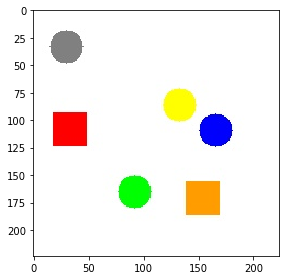

In [60]:
img2 = cv2.imread('data/train/images/2.jpg')
imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [61]:
nsai.executor.scene = nsai.perceiver.scene_repr(img2)
nsai.executor.scene

,shape,color,position
0,rectangle,orange,"(155, 172)"
1,rectangle,red,"(31, 108)"
2,circle,gray,"(31, 32)"
3,circle,green,"(91, 164)"
4,circle,blue,"(167, 108)"
5,circle,yellow,"(131, 84)"


In [78]:
# program = nsai.sem_parser.predict('How many objects of the same shape as the red object are there? ')
# program

In [80]:
# nsai.executor.count(nsai.executor.filter_(nsai.executor.query(nsai.executor.filter_('red'), 'shape')))